In [1]:
#Loading libraries
import json

import matplotlib.pyplot as plt
import numpy as np
import pyhf
from pyhf.contrib.viz import brazil

import scipy
from scipy import stats
import uproot3
import uproot
import math
import awkward as ak
import pickle

import csv

from importlib import reload

import Utilities.Constants as Constants
import Utilities.Functions as Functions
from Utilities.ipython_exit import exit

print("Successful!")

Successful!


In [2]:
Params_pyhf = {"Use_flat_sys_bkg":False,
               "Use_flat_sys_signal":True,
               "Stats_only":True,
               "Use_second_half_only":True,
               "Load_logit_hists":True,
               "Use_toys":False,
               "Num_toys":100,
               "Load_lepton_hists":True,
               "Load_pi0_hists":False,
               "Flat_overlay_bkg_frac":0.5,
               "Flat_dirt_bkg_frac":1.0,
               "Flat_sig_KDAR":0.5,
               "Flat_sig_detvar":0.2, #This is very conservative, could be fed in per mass point from signal detvar script
               "Signal_flux_error":0.3, #This comes from the KDAR flux uncertainty.
               "Overlay_detvar_frac":0.5}

Functions.pyhf_params(Params_pyhf)

Calculating stats-only limit.


In [3]:
#Loading My BDT histograms
# loc_hists = 'bdt_output/'
loc_hists = 'Uncertainties/'

hist_dict_run1 = {}
hist_dict_run3 = {}
theta_dict = {}

#Loading in the .root files
if Params_pyhf["Load_lepton_hists"] == True:
    for HNL_mass in Constants.HNL_mass_samples:
    # for HNL_mass in [10]:
        if Params_pyhf["Load_logit_hists"] == False:
            hist_dict_run1[HNL_mass] = uproot.open(loc_hists+f'run1_{HNL_mass}MeV_test2.root')
            hist_dict_run3[HNL_mass] = uproot.open(loc_hists+f'run3_{HNL_mass}MeV_test2.root')
        if Params_pyhf["Load_logit_hists"] == True:
            hist_dict_run1[HNL_mass] = uproot.open(loc_hists+f'run1_{HNL_mass}MeV_logit_NEWEST.root')
            hist_dict_run3[HNL_mass] = uproot.open(loc_hists+f'run3_{HNL_mass}MeV_logit_NEWEST.root')
        theta_dict[HNL_mass] = hist_dict_run1[HNL_mass]["theta_tree/theta"].array()[0][0] #assuming scaled theta is the same for all runs
    
if Params_pyhf["Load_pi0_hists"] == True:
    pi0_dict_run1, pi0_dict_run3 = {}, {}
    for HNL_mass in Constants.HNL_mass_pi0_samples:
        if Params_pyhf["Load_logit_hists"] == False:
            hist_dict_run1[HNL_mass] = uproot.open(loc_hists+f'pi0/run1_{HNL_mass}MeV_test1.root') #run1_150MeV_logit_test1.root
            hist_dict_run3[HNL_mass] = uproot.open(loc_hists+f'pi0/run3_{HNL_mass}MeV_test1.root')
        if Params_pyhf["Load_logit_hists"] == True:
            hist_dict_run1[HNL_mass] = uproot.open(loc_hists+f'pi0/run1_{HNL_mass}MeV_logit_test1.root')
            hist_dict_run3[HNL_mass] = uproot.open(loc_hists+f'pi0/run3_{HNL_mass}MeV_logit_test1.root')

#list_of_dicts = [hist_dict_run1, hist_dict_run3] #Add run2 when available, not using yet

#Constants
theta_squared = Constants.theta_mu_4*Constants.theta_mu_4

print("Success")

Success


## Loading in Uncertainties

In [4]:
def Calculate_total_uncertainty(Params, hist_dict, bkg_reweight_err_dict=None, bkg_detvar_dict=None, sig_detvar_dict=None): #Takes the dictionary of all root files
    BKG_ERR_dict, SIGNAL_ERR_dict = {}, {}
    for HNL_mass in hist_dict:
        bkg_stat_err_list = [hist_dict[HNL_mass]['bkg_overlay'].errors(), 
                             hist_dict[HNL_mass]['bkg_EXT'].errors(), 
                             hist_dict[HNL_mass]['bkg_dirt'].errors()]
        sig_stat_err = hist_dict[HNL_mass]['signal'].errors()
        if Params["Stats_only"] == True:
        #As default the errors saved in the files are stat errors, this will change once I properly calculate them
            bkg_err_list = bkg_stat_err_list
            sig_err = sig_stat_err
        elif Params["Use_flat_sys_bkg"] == True:
            zero_bins = []
            for i,val in enumerate(hist_dict[HNL_mass]['bkg_overlay'].values()):
                if val == 0:
                    zero_bins.append(i)
                    print(f"{HNL_mass} last bin 0, setting error to 2.0")
            if len(zero_bins) != 0:
                bkg_sys_err_list = [hist_dict[HNL_mass]['bkg_overlay'].values()*Params["Flat_overlay_bkg_frac"] + np.ones_like(hist_dict[HNL_mass]['bkg_overlay'].values())*2.0, #This is horrible need to rewrite 
                                    np.zeros_like(hist_dict[HNL_mass]['bkg_EXT'].errors()), #No systematic error on the EXT sample
                                    hist_dict[HNL_mass]['bkg_dirt'].values()*Params["Flat_dirt_bkg_frac"]]
            else:    
                bkg_sys_err_list = [hist_dict[HNL_mass]['bkg_overlay'].values()*Params["Flat_overlay_bkg_frac"], 
                                    np.zeros_like(hist_dict[HNL_mass]['bkg_EXT'].errors()), #No systematic error on the EXT sample
                                    hist_dict[HNL_mass]['bkg_dirt'].values()*Params["Flat_dirt_bkg_frac"]]
            bkg_err_list = [Functions.add_all_errors([bkg_stat_err_list[0],bkg_sys_err_list[0]]), #adding the sys and stat error in quadrature for each bkg type
                            Functions.add_all_errors([bkg_stat_err_list[1],bkg_sys_err_list[1]]),
                            Functions.add_all_errors([bkg_stat_err_list[2],bkg_sys_err_list[2]])]
        elif Params["Use_flat_sys_bkg"] == False:
            ppfx_unc = hist_dict[HNL_mass]["ppfx_uncertainty"].values()
            genie_unc = hist_dict[HNL_mass]["Genie_uncertainty"].values()
            reint_unc = hist_dict[HNL_mass]["Reinteraction_uncertainty"].values()
            # detvar_unc = bkg_detvar_dict[HNL_mass]["Total_DetVar_uncertainty"].values() #Don't know what this looks like yet, as I haven't made
            detvar_unc = hist_dict[HNL_mass]['bkg_overlay'].values()*Params["Overlay_detvar_frac"] #Just setting as flat. Too much variation in samples
            tot_overlay_sys = Functions.add_all_errors([ppfx_unc, genie_unc, reint_unc, detvar_unc])
            bkg_sys_err_list = [tot_overlay_sys, 
                                np.zeros_like(hist_dict[HNL_mass]['bkg_EXT'].errors()), #No systematic error on the EXT sample
                                hist_dict[HNL_mass]['bkg_dirt'].values()*Params["Flat_dirt_bkg_frac"]] #Don't have reweight or DetVar samples for dirt
            bkg_err_list = [Functions.add_all_errors([bkg_stat_err_list[0],bkg_sys_err_list[0]]), #adding the sys and stat error in quadrature for each bkg type
                            Functions.add_all_errors([bkg_stat_err_list[1],bkg_sys_err_list[1]]),
                            Functions.add_all_errors([bkg_stat_err_list[2],bkg_sys_err_list[2]])]
        if (Params["Stats_only"] == False) and (Params["Use_flat_sys_signal"] == True):
            zero_bins = []
            for i,val in enumerate(hist_dict[HNL_mass]['signal'].values()):
                if val == 0:
                    zero_bins.append(i)
                    print(f"{HNL_mass} signal last bin 0, setting error to 2.0")
            if len(zero_bins) != 0:
                sig_sys_err = hist_dict[HNL_mass]['signal'].values()*Params["Flat_sig_frac"]+2.0
            else:
                sig_sys_err = hist_dict[HNL_mass]['signal'].values()*Params["Flat_sig_frac"]
            sig_err = Functions.add_all_errors([sig_stat_err,sig_sys_err])
        if (Params["Stats_only"] == False) and (Params["Use_flat_sys_signal"] == False):
            sig_detvar_err = sig_detvar_dict[HNL_mass]["Total_DetVar_uncertainty"].values()
            sig_flux_err = hist_dict[HNL_mass]['signal'].values()*Params["Signal_flux_error"]
            sig_err = Functions.add_all_errors([sig_stat_err,sig_detvar_err,sig_flux_err]) #Adding stat, detvar and flux errors in quadrature
        total_bkg_err = Functions.add_all_errors(bkg_err_list) #Now adding the errors of overlay, EXT and dirt in quadrature
        BKG_ERR_dict[HNL_mass] = total_bkg_err
        SIGNAL_ERR_dict[HNL_mass] = sig_err
    return BKG_ERR_dict, SIGNAL_ERR_dict

def Uncertainty_breakdown(Params, hist_dict, bkg_reweight_err_dict=None, bkg_detvar_dict=None, sig_detvar_dict=None): #Takes the dictionary of all root files
    BKG_ERR_dict, SIGNAL_ERR_dict = {}, {}
    for HNL_mass in hist_dict:
        bkg_stat_err_list = [hist_dict[HNL_mass]['bkg_overlay'].errors(), 
                             hist_dict[HNL_mass]['bkg_EXT'].errors(), 
                             hist_dict[HNL_mass]['bkg_dirt'].errors()]
        sig_stat_err = hist_dict[HNL_mass]['signal'].errors()
        print("Signal stat error:")
        print(sig_stat_err)
        if Params["Stats_only"] == True:
        #As default the errors saved in the files are stat errors, this will change once I properly calculate them
            bkg_err_list = bkg_stat_err_list
            sig_err = sig_stat_err
        elif Params["Use_flat_sys_bkg"] == True:
            zero_bins = []
            for i,val in enumerate(hist_dict[HNL_mass]['bkg_overlay'].values()):
                if val == 0:
                    zero_bins.append(i)
                    print(f"{HNL_mass} last bin 0, setting error to 2.0")
            if len(zero_bins) != 0:
                bkg_sys_err_list = [hist_dict[HNL_mass]['bkg_overlay'].values()*Params["Flat_overlay_bkg_frac"] + np.ones_like(hist_dict[HNL_mass]['bkg_overlay'].values())*2.0, #This is horrible need to rewrite 
                                    np.zeros_like(hist_dict[HNL_mass]['bkg_EXT'].errors()), #No systematic error on the EXT sample
                                    hist_dict[HNL_mass]['bkg_dirt'].values()*Params["Flat_dirt_bkg_frac"]]
            else:    
                bkg_sys_err_list = [hist_dict[HNL_mass]['bkg_overlay'].values()*Params["Flat_overlay_bkg_frac"], 
                                    np.zeros_like(hist_dict[HNL_mass]['bkg_EXT'].errors()), #No systematic error on the EXT sample
                                    hist_dict[HNL_mass]['bkg_dirt'].values()*Params["Flat_dirt_bkg_frac"]]
            bkg_err_list = [Functions.add_all_errors([bkg_stat_err_list[0],bkg_sys_err_list[0]]), #adding the sys and stat error in quadrature for each bkg type
                            Functions.add_all_errors([bkg_stat_err_list[1],bkg_sys_err_list[1]]),
                            Functions.add_all_errors([bkg_stat_err_list[2],bkg_sys_err_list[2]])]
        elif Params["Use_flat_sys_bkg"] == False:
            ppfx_unc = hist_dict[HNL_mass]["ppfx_uncertainty"].values()
            genie_unc = hist_dict[HNL_mass]["Genie_uncertainty"].values()
            reint_unc = hist_dict[HNL_mass]["Reinteraction_uncertainty"].values()
            # detvar_unc = bkg_detvar_dict[HNL_mass]["Total_DetVar_uncertainty"].values() #Don't know what this looks like yet, as I haven't made
            detvar_unc = hist_dict[HNL_mass]['bkg_overlay'].values()*Params["Overlay_detvar_frac"] #Just setting as flat. Too much variation in samples
            tot_overlay_sys = Functions.add_all_errors([ppfx_unc, genie_unc, reint_unc, detvar_unc])
            bkg_sys_err_list = [tot_overlay_sys, 
                                np.zeros_like(hist_dict[HNL_mass]['bkg_EXT'].errors()), #No systematic error on the EXT sample
                                hist_dict[HNL_mass]['bkg_dirt'].values()*Params["Flat_dirt_bkg_frac"]] #Don't have reweight or DetVar samples for dirt
            bkg_err_list = [Functions.add_all_errors([bkg_stat_err_list[0],bkg_sys_err_list[0]]), #adding the sys and stat error in quadrature for each bkg type
                            Functions.add_all_errors([bkg_stat_err_list[1],bkg_sys_err_list[1]]),
                            Functions.add_all_errors([bkg_stat_err_list[2],bkg_sys_err_list[2]])]
            bkg_stat_err_total = Functions.add_all_errors([bkg_stat_err_list[0],bkg_stat_err_list[1],bkg_stat_err_list[2]])
            print("bkg stat error:")
            print(bkg_stat_err_total)
            print("bkg flux error:")
            print(ppfx_unc)
            print("bkg genie error:")
            print(genie_unc)
            print("bkg reint error:")
            print(reint_unc)
            
        if (Params["Stats_only"] == False) and (Params["Use_flat_sys_signal"] == True):
            zero_bins = []
            for i,val in enumerate(hist_dict[HNL_mass]['signal'].values()):
                if val == 0:
                    zero_bins.append(i)
                    print(f"{HNL_mass} signal last bin 0, setting error to 2.0")
            if len(zero_bins) != 0:
                sig_sys_err = hist_dict[HNL_mass]['signal'].values()*Params["Flat_sig_frac"]+2.0
            else:
                sig_sys_err = hist_dict[HNL_mass]['signal'].values()*Params["Flat_sig_frac"]
            sig_err = Functions.add_all_errors([sig_stat_err,sig_sys_err])
        if (Params["Stats_only"] == False) and (Params["Use_flat_sys_signal"] == False):
            sig_detvar_err = sig_detvar_dict[HNL_mass]["Total_DetVar_uncertainty"].values()
            sig_flux_err = hist_dict[HNL_mass]['signal'].values()*Params["Signal_flux_error"]
            sig_err = Functions.add_all_errors([sig_stat_err,sig_detvar_err,sig_flux_err]) #Adding stat, detvar and flux errors in quadrature
        total_bkg_err = Functions.add_all_errors(bkg_err_list) #Now adding the errors of overlay, EXT and dirt in quadrature
        BKG_ERR_dict[HNL_mass] = total_bkg_err
        SIGNAL_ERR_dict[HNL_mass] = sig_err
        print("Total bkg error:")
        print(total_bkg_err)
        print("Total signal error:")
        print(sig_err)
    return BKG_ERR_dict, SIGNAL_ERR_dict
    
def Add_bkg_hists_make_signal(hist_dict):
    BKG_dict, SIGNAL_dict = {}, {}
    for HNL_mass in hist_dict:
        bkg_hists = [hist_dict[HNL_mass]['bkg_EXT'], hist_dict[HNL_mass]['bkg_overlay'], hist_dict[HNL_mass]['bkg_dirt']]
        
        total_bkg = Functions.add_hists_vals(bkg_hists)
        BKG_dict[HNL_mass] = total_bkg
        SIGNAL_dict[HNL_mass] = hist_dict[HNL_mass]['signal'].values()
 
    return BKG_dict, SIGNAL_dict


In [32]:
def create_model_dict(Total_dict):
    model_dict = {}
    
    for HNL_mass in Total_dict:
        print(HNL_mass)
        model_dict[HNL_mass] = pyhf.Model(
        {
      "channels": [
        {
          "name": "singlechannel",
          "samples": [
            {
              "name": "signal",
              "data": Total_dict[HNL_mass]["SIGNAL_dict"],
              "modifiers": [
                {
                  "name": "mu",
                  "type": "normfactor",
                  "data": None
                },
                {
                  "name": "uncorr_siguncrt",
                  "type": "shapesys",
                  "data": Total_dict[HNL_mass]["SIGNAL_ERR_dict"]  
                }
              ]
            },
            {
              "name": "background",
              "data": Total_dict[HNL_mass]["BKG_dict"],
              "modifiers": [
                {
                  "name": "uncorr_bkguncrt",
                  "type": "shapesys",
                  "data": Total_dict[HNL_mass]["BKG_ERR_dict"]
                }
              ]
            }
          ]
        }
      ]
    }
    )
    return model_dict

In [6]:
R1_BKG_ERR_dict, R1_SIGNAL_ERR_dict = Calculate_total_uncertainty(Params_pyhf, hist_dict_run1)
R3_BKG_ERR_dict, R3_SIGNAL_ERR_dict = Calculate_total_uncertainty(Params_pyhf, hist_dict_run3)

R1_BKG, R1_SIGNAL = Add_bkg_hists_make_signal(hist_dict_run1)
R3_BKG, R3_SIGNAL = Add_bkg_hists_make_signal(hist_dict_run3)

R1_output = Functions.Make_into_lists(Params_pyhf, R1_BKG, R1_SIGNAL, R1_BKG_ERR_dict, R1_SIGNAL_ERR_dict)
R3_output = Functions.Make_into_lists(Params_pyhf, R3_BKG, R3_SIGNAL, R3_BKG_ERR_dict, R3_SIGNAL_ERR_dict)

list_input_dicts = [R1_output, R3_output]
# list_input_dicts = [R1_output, R1_output] #Used when I didn't have Run3

Total_dict = Functions.Create_final_appended_runs_dict(list_input_dicts)

dict_keys([2, 10, 20, 50, 100, 150, 180, 200, 220, 240, 245])


In [ ]:
# print(Total_dict[2].keys())
# print(Total_dict[2]['BKG_dict'])
# print(Total_dict[2]['BKG_ERR_dict'])

HNL_mass = 100
test_dict = {}
test_dict[HNL_mass] = hist_dict_run3[HNL_mass]

print("Signal:")
print(test_dict[HNL_mass]['signal'].values())
print("Background:")
print(test_dict[HNL_mass]['bkg_overlay'].values() + test_dict[HNL_mass]['bkg_EXT'].values() + test_dict[HNL_mass]['bkg_dirt'].values())
print()
print("Bkg overlay:")
print(test_dict[HNL_mass]['bkg_overlay'].values())
print("Bkg EXT:")
print(test_dict[HNL_mass]['bkg_EXT'].values())
print("Bkg dirt:")
print(test_dict[HNL_mass]['bkg_dirt'].values())
print()

TEST_BKG_ERR_dict, TEST_SIGNAL_ERR_dict = Uncertainty_breakdown(Params_pyhf, test_dict)

In [7]:
model_dict = create_model_dict(Total_dict)

## Testing single point

In [ ]:
HNL_mass = 10 #Mass point to test
DATA_OBS_dict = {}
obs_limit_dict = {}
exp_limits_dict = {}
init_pars = model_dict[HNL_mass].config.suggested_init()
model_dict[HNL_mass].expected_actualdata(init_pars) #signal plus bkg

bkg_pars = init_pars.copy()
bkg_pars[model_dict[HNL_mass].config.poi_index] = 0
model_dict[HNL_mass].expected_actualdata(bkg_pars) #bkg only

DATA_OBS_dict[HNL_mass] = Total_dict[HNL_mass]["BKG_dict"]+model_dict[HNL_mass].config.auxdata

model_dict[HNL_mass].logpdf(pars=bkg_pars, data=DATA_OBS_dict[HNL_mass])

CLs_obs, CLs_exp = pyhf.infer.hypotest(
            1.0,  # null hypothesis
            DATA_OBS_dict[HNL_mass],
            model_dict[HNL_mass],
            test_stat="qtilde",
            return_expected_set=True,
            calctype="asymptotics",
            )
for expected_value, n_sigma in zip(CLs_exp, np.arange(-1, 2)):
    print(f"Expected CLs({n_sigma:2d} σ): {expected_value:.4f}")
    
poi_values = np.linspace(0.001, 10, 50)
obs_limit_single, exp_limits_single, (scan, results) = pyhf.infer.intervals.upperlimit(DATA_OBS_dict[HNL_mass], 
                                                                                       model_dict[HNL_mass], poi_values, 
                                                                                       level=0.1, return_results=True)
print(f"Upper limit {HNL_mass}MeV (obs): μ = {obs_limit_single:.4f}")
print(f"Upper limit {HNL_mass}MeV (exp): μ = {exp_limits_single[2]:.4f}" + "\n")

In [ ]:
exp_limit = []
obs_limit = []

# for HNL_mass in Constants.HNL_mass_samples:
for HNL_mass in [10]:
    theta_squared = (theta_dict[HNL_mass])**2

    EXP_LIMIT = np.sqrt(exp_limits_single[2])*theta_squared
    LIMIT = np.sqrt(obs_limit_single)*theta_squared
    print(f"Expected {HNL_mass}MeV limit is " + str(EXP_LIMIT))
    print(f"Observed {HNL_mass}MeV limit is " + str(LIMIT)+ "\n")
    
    exp_limit.append(EXP_LIMIT)

## Running through all points

In [ ]:
list_test = Constants.HNL_mass_samples
print(list_test)

In [ ]:
DATA_OBS_dict = {}

# for HNL_mass in Constants.HNL_mass_samples: #removing the 240MeV point
for HNL_mass in list_test:
    init_pars = model_dict[HNL_mass].config.suggested_init()
    model_dict[HNL_mass].expected_actualdata(init_pars) #signal plus bkg

    bkg_pars = init_pars.copy()
    bkg_pars[model_dict[HNL_mass].config.poi_index] = 0
    model_dict[HNL_mass].expected_actualdata(bkg_pars) #bkg only

    DATA_OBS_dict[HNL_mass] = Total_dict[HNL_mass]["BKG_dict"]+model_dict[HNL_mass].config.auxdata

    model_dict[HNL_mass].logpdf(pars=bkg_pars, data=DATA_OBS_dict[HNL_mass])

In [ ]:
# for HNL_mass in Constants.HNL_mass_samples:
for HNL_mass in list_test:

    if Params_pyhf["Use_toys"] == False:
        CLs_obs, CLs_exp = pyhf.infer.hypotest(
            1.0,  # null hypothesis
            DATA_OBS_dict[HNL_mass],
            model_dict[HNL_mass],
            test_stat="qtilde",
            return_expected_set=True,
            calctype="asymptotics",
            )
    if Params_pyhf["Use_toys"] == True:
        CLs_obs, CLs_exp = pyhf.infer.hypotest(
            1.0,  # null hypothesis
            DATA_OBS_dict[HNL_mass],
            model_dict[HNL_mass],
            test_stat="qtilde",
            return_expected_set=True,
            calctype="toybased",
            ntoys=Params_pyhf["Num_toys"],
            track_progress=True,
            )
    
    print(f"{HNL_mass}MeV")
    for expected_value, n_sigma in zip(CLs_exp, np.arange(-2, 3)):
        print(f"Expected CLs({n_sigma:2d} σ): {expected_value:.4f}")

In [ ]:
obs_limit_dict = {}
exp_limits_dict = {}
print("If the output of the following is equal to the lowest or highest value of poi, the range needs to be extended")

poi_values = np.linspace(0.001, 2, 100) #I could make a dict of this and have different pois for different mass points
print("Max value is " + str(max(poi_values)))
print("Min value is " + str(min(poi_values)))
print("Next value is " + str(poi_values[1]))
print("Next value is " + str(poi_values[2]) + "\n")
# for HNL_mass in Constants.HNL_mass_samples:
# list_test = [180, 200, 220, 240, 245]
for HNL_mass in list_test:

    # poi_values = np.linspace(0.001, 4, 100)
    obs_limit_dict[HNL_mass], exp_limits_dict[HNL_mass], (scan, results) = pyhf.infer.intervals.upperlimit(
        DATA_OBS_dict[HNL_mass], model_dict[HNL_mass], poi_values, level=0.1, return_results=True
    )

    print(f"Upper limit {HNL_mass}MeV (obs): μ = {obs_limit_dict[HNL_mass]:.6f}")
    print(f"Upper limit {HNL_mass}MeV (exp): μ = {exp_limits_dict[HNL_mass][2]:.6f}" + "\n")

In [ ]:
exp_limit = [] #entry 2
exp_1sig_up = [] #entry 3
exp_1sig_down = [] #entry 1
exp_2sig_up = [] #entry 4
exp_2sig_down = [] #entry 0
obs_limit = []

# for HNL_mass in Constants.HNL_mass_samples:
for HNL_mass in exp_limits_dict:
    theta_squared = (theta_dict[HNL_mass])**2
    print(theta_squared)

    EXP_LIMIT = np.sqrt(exp_limits_dict[HNL_mass][2])*theta_squared
    exp_1sig_up.append(np.sqrt(exp_limits_dict[HNL_mass][3])*theta_squared)
    exp_2sig_up.append(np.sqrt(exp_limits_dict[HNL_mass][4])*theta_squared)
    exp_1sig_down.append(np.sqrt(exp_limits_dict[HNL_mass][1])*theta_squared)
    exp_2sig_down.append(np.sqrt(exp_limits_dict[HNL_mass][0])*theta_squared)
    
    LIMIT = np.sqrt(obs_limit_dict[HNL_mass])*theta_squared
    # if HNL_mass in Constants.Old_generator_mass_points:
    #     EXP_LIMIT = EXP_LIMIT*np.sqrt(1/Constants.Old_gen_HNL_scalings[HNL_mass])
    #     LIMIT = LIMIT*np.sqrt(1/Constants.Old_gen_HNL_scalings[HNL_mass])
    print(f"Expected {HNL_mass}MeV limit is " + str(EXP_LIMIT))
    print(f"Observed {HNL_mass}MeV limit is " + str(LIMIT)+ "\n")
    
    exp_limit.append(EXP_LIMIT)

## Saving limit as .csv

In [ ]:
masses = Constants.HNL_mass_samples
# masses = list_test

if Params_pyhf["Stats_only"] == True:
    stats =  "Stats_only"
else:
    stats = "Flat_sys"
    
if Params_pyhf["Use_second_half_only"] == True:
    half_hist = "havled"
else:
    half_hist = "full_hist"

print(masses)
print(exp_limit)

r = zip(masses, exp_limit)
if Params_pyhf["Load_pi0_hists"] == False:
    with open(f'limit_files/My_limits/{stats}_{half_hist}_expected_mu_top_20_logit_FIXED.csv', "w") as s:
        w = csv.writer(s)
        for row in r:
            w.writerow(row)
            
if Params_pyhf["Load_pi0_hists"] == True:
    with open(f'limit_files/My_limits/{stats}_{half_hist}_expected_pi0_mu_all_vars_logit_FIXED.csv', "w") as s:
        w = csv.writer(s)
        for row in r:
            w.writerow(row)


## Testing adjacent models

In [45]:
adjacent_hist_dict_run1, adjacent_hist_dict_run3 = {}, {}
R1_BKG_ERR_dict_ADJ, R3_BKG_ERR_dict_ADJ, R1_SIGNAL_ERR_dict_ADJ, R3_SIGNAL_ERR_dict_ADJ = {}, {}, {}, {}
mass_point = 50
test_models = [20, 100]
for mass_model in test_models:
    adjacent_hist_dict_run1[mass_model] = uproot.open(f'bdt_output/adjacent_models/run1_{mass_point}MeV_{mass_model}MeV_model.root')
    adjacent_hist_dict_run3[mass_model] = uproot.open(f'bdt_output/adjacent_models/run3_{mass_point}MeV_{mass_model}MeV_model.root')
    R1_BKG_ERR_dict_ADJ, R1_SIGNAL_ERR_dict_ADJ = Calculate_total_uncertainty(Params_pyhf, adjacent_hist_dict_run1)
    R3_BKG_ERR_dict_ADJ, R3_SIGNAL_ERR_dict_ADJ = Calculate_total_uncertainty(Params_pyhf, adjacent_hist_dict_run3)
    # R1_BKG_ERR_dict_ADJ[mass_model]=R1_BKG_ERR_dict[mass_point]
    # R3_BKG_ERR_dict_ADJ[mass_model]=R3_BKG_ERR_dict[mass_point]
    # R1_SIGNAL_ERR_dict_ADJ[mass_model]=R1_SIGNAL_ERR_dict[mass_point]
    # R3_SIGNAL_ERR_dict_ADJ[mass_model]=R3_SIGNAL_ERR_dict[mass_point]
adjacent_hist_dict_run1[mass_point] = hist_dict_run1[mass_point]
adjacent_hist_dict_run3[mass_point] = hist_dict_run3[mass_point]
R1_BKG_ERR_dict_ADJ[mass_point]=R1_BKG_ERR_dict[mass_point]
R3_BKG_ERR_dict_ADJ[mass_point]=R3_BKG_ERR_dict[mass_point]
R1_SIGNAL_ERR_dict_ADJ[mass_point]=R1_SIGNAL_ERR_dict[mass_point]
R3_SIGNAL_ERR_dict_ADJ[mass_point]=R3_SIGNAL_ERR_dict[mass_point]

R1_BKG_ADJ, R1_SIGNAL_ADJ = Add_bkg_hists_make_signal(adjacent_hist_dict_run1)
R3_BKG_ADJ, R3_SIGNAL_ADJ = Add_bkg_hists_make_signal(adjacent_hist_dict_run3)

R1_output_ADJ = Functions.Make_into_lists(Params_pyhf, R1_BKG_ADJ, R1_SIGNAL_ADJ, R1_BKG_ERR_dict_ADJ, R1_SIGNAL_ERR_dict_ADJ)
R3_output_ADJ = Functions.Make_into_lists(Params_pyhf, R3_BKG_ADJ, R3_SIGNAL_ADJ, R3_BKG_ERR_dict_ADJ, R3_SIGNAL_ERR_dict_ADJ)

list_input_dicts_ADJ = [R1_output_ADJ, R3_output_ADJ]
# list_input_dicts = [R1_output, R1_output] #Used when I didn't have Run3

Total_dict_ADJ = Functions.Create_final_appended_runs_dict(list_input_dicts_ADJ)
print(Total_dict_ADJ[100].keys())

dict_keys([20, 100, 50])
dict_keys(['BKG_dict', 'BKG_ERR_dict', 'SIGNAL_dict', 'SIGNAL_ERR_dict'])


In [46]:
print(Total_dict.keys())

dict_keys([2, 10, 20, 50, 100, 150, 180, 200, 220, 240, 245])


In [47]:
model_dict_ADJ = create_model_dict(Total_dict_ADJ)

20
100
50


In [48]:
list_test = adjacent_hist_dict_run1.keys()
DATA_OBS_dict = {}

# for HNL_mass in Constants.HNL_mass_samples: #removing the 240MeV point
for HNL_mass in list_test:
    init_pars = model_dict[HNL_mass].config.suggested_init()
    model_dict[HNL_mass].expected_actualdata(init_pars) #signal plus bkg

    bkg_pars = init_pars.copy()
    bkg_pars[model_dict[HNL_mass].config.poi_index] = 0
    model_dict[HNL_mass].expected_actualdata(bkg_pars) #bkg only

    DATA_OBS_dict[HNL_mass] = Total_dict[HNL_mass]["BKG_dict"]+model_dict[HNL_mass].config.auxdata

    model_dict[HNL_mass].logpdf(pars=bkg_pars, data=DATA_OBS_dict[HNL_mass])

In [49]:
for HNL_mass in list_test:

    if Params_pyhf["Use_toys"] == False:
        CLs_obs, CLs_exp = pyhf.infer.hypotest(
            1.0,  # null hypothesis
            DATA_OBS_dict[HNL_mass],
            model_dict[HNL_mass],
            test_stat="qtilde",
            return_expected_set=True,
            calctype="asymptotics",
            )
    if Params_pyhf["Use_toys"] == True:
        CLs_obs, CLs_exp = pyhf.infer.hypotest(
            1.0,  # null hypothesis
            DATA_OBS_dict[HNL_mass],
            model_dict[HNL_mass],
            test_stat="qtilde",
            return_expected_set=True,
            calctype="toybased",
            ntoys=Params_pyhf["Num_toys"],
            track_progress=True,
            )
    
    print(f"{HNL_mass}MeV")
    for expected_value, n_sigma in zip(CLs_exp, np.arange(-2, 3)):
        print(f"Expected CLs({n_sigma:2d} σ): {expected_value:.4f}")

20MeV
Expected CLs(-2 σ): 0.0000
Expected CLs(-1 σ): 0.0000
Expected CLs( 0 σ): 0.0000
Expected CLs( 1 σ): 0.0000
Expected CLs( 2 σ): 0.0000
100MeV
Expected CLs(-2 σ): 0.0001
Expected CLs(-1 σ): 0.0014
Expected CLs( 0 σ): 0.0121
Expected CLs( 1 σ): 0.0780
Expected CLs( 2 σ): 0.3124
50MeV
Expected CLs(-2 σ): 0.0000
Expected CLs(-1 σ): 0.0000
Expected CLs( 0 σ): 0.0000
Expected CLs( 1 σ): 0.0000
Expected CLs( 2 σ): 0.0000


In [51]:
obs_limit_dict = {}
exp_limits_dict = {}
print("If the output of the following is equal to the lowest or highest value of poi, the range needs to be extended")

poi_values = np.linspace(0.001, 2, 100) #I could make a dict of this and have different pois for different mass points
print("Max value is " + str(max(poi_values)))
print("Min value is " + str(min(poi_values)))
print("Next value is " + str(poi_values[1]))
print("Next value is " + str(poi_values[2]) + "\n")
# for HNL_mass in Constants.HNL_mass_samples:
# list_test = [180, 200, 220, 240, 245]
for HNL_mass in list_test:

    # poi_values = np.linspace(0.001, 4, 100)
    obs_limit_dict[HNL_mass], exp_limits_dict[HNL_mass], (scan, results) = pyhf.infer.intervals.upperlimit(
        DATA_OBS_dict[HNL_mass], model_dict[HNL_mass], poi_values, level=0.1, return_results=True
    )

    print(f"Upper limit {HNL_mass}MeV (obs): μ = {obs_limit_dict[HNL_mass]:.6f}")
    print(f"Upper limit {HNL_mass}MeV (exp): μ = {exp_limits_dict[HNL_mass][2]:.6f}" + "\n")

If the output of the following is equal to the lowest or highest value of poi, the range needs to be extended
Max value is 2.0
Min value is 0.001
Next value is 0.021191919191919192
Next value is 0.041383838383838384

Upper limit 20MeV (obs): μ = 0.087209
Upper limit 20MeV (exp): μ = 0.087209

Upper limit 100MeV (obs): μ = 0.629815
Upper limit 100MeV (exp): μ = 0.629815

Upper limit 50MeV (obs): μ = 0.076459
Upper limit 50MeV (exp): μ = 0.076459



In [52]:
exp_limit = [] #entry 2
exp_1sig_up = [] #entry 3
exp_1sig_down = [] #entry 1
exp_2sig_up = [] #entry 4
exp_2sig_down = [] #entry 0
obs_limit = []

# for HNL_mass in Constants.HNL_mass_samples:
for HNL_mass in exp_limits_dict:
    theta_squared = (theta_dict[mass_point])**2
    print(theta_squared)

    EXP_LIMIT = np.sqrt(exp_limits_dict[HNL_mass][2])*theta_squared
    exp_1sig_up.append(np.sqrt(exp_limits_dict[HNL_mass][3])*theta_squared)
    exp_2sig_up.append(np.sqrt(exp_limits_dict[HNL_mass][4])*theta_squared)
    exp_1sig_down.append(np.sqrt(exp_limits_dict[HNL_mass][1])*theta_squared)
    exp_2sig_down.append(np.sqrt(exp_limits_dict[HNL_mass][0])*theta_squared)
    
    LIMIT = np.sqrt(obs_limit_dict[HNL_mass])*theta_squared
    # if HNL_mass in Constants.Old_generator_mass_points:
    #     EXP_LIMIT = EXP_LIMIT*np.sqrt(1/Constants.Old_gen_HNL_scalings[HNL_mass])
    #     LIMIT = LIMIT*np.sqrt(1/Constants.Old_gen_HNL_scalings[HNL_mass])
    print(f"Expected {HNL_mass}MeV limit is " + str(EXP_LIMIT))
    print(f"Observed {HNL_mass}MeV limit is " + str(LIMIT)+ "\n")
    
    exp_limit.append(EXP_LIMIT)

2.5e-05
Expected 20MeV limit is 7.3827958770328454e-06
Observed 20MeV limit is 7.3827958770328454e-06

2.5e-05
Expected 100MeV limit is 1.9840221581842897e-05
Observed 100MeV limit is 1.9840221581842897e-05

2.5e-05
Expected 50MeV limit is 6.912810521978472e-06
Observed 50MeV limit is 6.912810521978472e-06



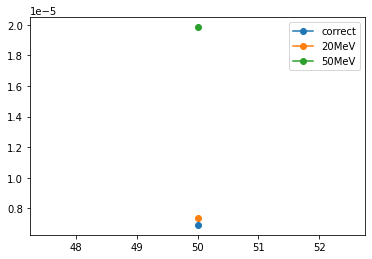

In [60]:
points = [6.912810521978472e-06, 7.3827958770328454e-06, 1.9840221581842897e-05]
x_points = [50, 50, 50]
labels = ["correct", "20MeV", "50MeV"]
for i, point in enumerate(points):
    plt.plot(x_points[i],point,label=labels[i],marker="o")
plt.legend()

In [61]:
rat_20 = 6.912810521978472e-06/7.3827958770328454e-06
rat_100 = 6.912810521978472e-06/1.9840221581842897e-05
print("20MeV model is " + str(rat_20))
print("100MeV model is " + str(rat_100))

20MeV model is 0.9363404646583211
100MeV model is 0.3484240583434231


## Brazil plot

In [ ]:
plt.figure(figsize=(14,8),facecolor='white',dpi=100)

savefig = True
# exp_limit = [] #entry 2
# exp_1sig_up = [] #entry 3
# exp_1sig_down = [] #entry 1
# exp_2sig_up = [] #entry 4
# exp_2sig_down = [] #entry 0

# plt.plot(masses_hnl_val,np.sqrt(np.array(obs_limit)),lw=5,ls='-',color='black',label='Observed')
plt.plot(Constants.HNL_mass_samples,np.array(exp_limit),lw=2,ls='--',color='red',label='Expected')
plt.fill_between(Constants.HNL_mass_samples,np.array(exp_2sig_down),np.array(exp_2sig_up),color='yellow',label=r'Exp. 2$\sigma$')
plt.fill_between(Constants.HNL_mass_samples,np.array(exp_1sig_down),np.array(exp_1sig_up),color='lightgreen',label=r'Exp. 1$\sigma$')
# plt.fill_between(masses,m2s,p2s,color='lightgreen',label=r'Exp. 2$\sigma$')
# plt.grid(ls='--',color='C7',alpha=0.1)

plt.ylabel(r'$|U_{\mu 4}|^2$ Limit at 90% CL',fontsize=20)
plt.xlabel('HNL Mass [MeV]',fontsize=20)
# plt.title("HNL Mixing Upper Limit")
plt.ylim(1e-8,1e-3)
plt.legend(loc="lower left",ncol=2,frameon=False,fontsize=20)
# plt.text(0.99,0.95,r'MicroBooNE NuMI POT:$7.01\times 10^{20}$',fontsize=20,color='black',alpha=1,verticalalignment='top',horizontalalignment='right',transform=plt.gca().transAxes)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.xlim(0,250)
plt.yscale('log')
plt.tight_layout()

if savefig == True:
    plt.savefig('plots/Limits/Brazil_preliminary.pdf',bbox_inches='tight', pad_inches=0.3)

plt.grid(False)


## End of code

In [ ]:
print_vals = input("Do you want to run with new pois? y/n ")
if print_vals == "y":
    poi_new_dict = {}
    for HNL_mass in list_test:
        best_fit_value = exp_limits_dict[HNL_mass][2]
        new_poi_array = np.linspace(0.001, best_fit_value*2, 100)
        poi_new_dict[HNL_mass] = new_poi_array

    obs_limit_dict = {}
    exp_limits_dict = {}
    print("If the output of the following is equal to the lowest or highest value of poi, the range needs to be extended")

    # for HNL_mass in Constants.HNL_mass_samples:
    for HNL_mass in list_test:

        obs_limit_dict[HNL_mass], exp_limits_dict[HNL_mass], (scan, results) = pyhf.infer.intervals.upperlimit(
            DATA_OBS_dict[HNL_mass], model_dict[HNL_mass], poi_new_dict[HNL_mass], level=0.1, return_results=True
        )

        print(f"Upper limit {HNL_mass}MeV (obs): μ = {obs_limit_dict[HNL_mass]:.4f}")
        print(f"Upper limit {HNL_mass}MeV (exp): μ = {exp_limits_dict[HNL_mass][2]:.4f}" + "\n")

## Finished code

In [ ]:
# def New_BR_limit(Old_theta_squared, HNL_mass):
#     New_limit = Old_theta_squared*np.sqrt(1/Constants.Old_gen_HNL_scalings[HNL_mass])
#     print("Old limit was " + str(Old_theta_squared))
#     print("New limit is " + str(New_limit))
#     return New_limit

# Old_limits = {20:0.00015681119188699395,
#               50:9.92373190724973e-06,
#               100:9.84200063077575e-07,
#               150:1.2830647341135436e-07,
#               180:7.604092480424186e-08}

In [ ]:
# New_limits = []
# for HNL_mass in list_test:
#     New_limits.append(New_BR_limit(Old_limits[HNL_mass], HNL_mass))
    
# r = zip([20,50,100,150,180], New_limits)

# with open(f'limit_files/New_BR_expected_mu.csv', "w") as s:
#     w = csv.writer(s)
#     for row in r:
#         w.writerow(row)

In [ ]:
# for HNL_mass in Constants.HNL_mass_samples:
#     new_scaling = np.sqrt(1/Constants.Old_gen_HNL_scalings[HNL_mass])
#     print("New scaling is " + str(new_scaling))


In [ ]:
print(Total_dict[20]["SIGNAL_ERR_dict"])

#print(Total_dict[20]["SIGNAL_dict"])

In [ ]:
TOTAL_SIGNAL_dict = {}
TOTAL_SIGNAL_ERR_dict = {}
TOTAL_BKG_dict = {}
TOTAL_BKG_ERR_dict = {}
TOTAL_DATA_dict = {}

for HNL_mass in HNL_masses:
    
    r1_signal = hist_dict_run1[HNL_mass]['signal']
    r1_EXT = hist_dict_run1[HNL_mass]['bkg_EXT']
    r1_nu = hist_dict_run1[HNL_mass]['bkg_overlay']
    r1_dirt = hist_dict_run1[HNL_mass]['bkg_dirt']
    r1_data = hist_dict_run1[HNL_mass]['data']
    
    r3_signal = hist_dict_run3[HNL_mass]['signal']
    r3_EXT = hist_dict_run3[HNL_mass]['bkg_EXT']
    r3_nu = hist_dict_run3[HNL_mass]['bkg_overlay']
    r3_dirt = hist_dict_run3[HNL_mass]['bkg_dirt']
    r3_data = hist_dict_run3[HNL_mass]['data']
    
    r1_bkg_hists = [r1_EXT, r1_nu, r1_dirt]
    r1_total_bkg = add_hists_vals(r1_bkg_hists)
    
    r3_bkg_hists = [r3_EXT, r3_nu, r3_dirt]
    r3_total_bkg = add_hists_vals(r3_bkg_hists)
    
    if Params_pyhf["Stats_only"] == True:
        overlay_r1_err = get_stat_errors(r1_nu)
        dirt_r1_err = get_stat_errors(r1_dirt)
        
        overlay_r3_err = get_stat_errors(r3_nu)
        dirt_r3_err = get_stat_errors(r3_dirt)
        
        r1_sig_err = get_stat_errors(r1_signal)
        r3_sig_err = get_stat_errors(r3_signal)
        
    elif Params_pyhf["Stats_only"] == False:
        overlay_r1_err = get_full_errors_nu_FLAT_INPUTS(r1_nu)
        dirt_r1_err = get_full_errors_dirt(r1_dirt)
      
        overlay_r3_err = get_full_errors_nu_FLAT_INPUTS(r3_nu)
        dirt_r3_err = get_full_errors_dirt(r3_dirt)
        
        r1_sig_err = get_full_errors_signal(r1_signal)
        r3_sig_err = get_full_errors_signal(r3_signal)
    
    
    r1_bkg_err_list = [overlay_r1_err, r1_EXT.errors(), dirt_r1_err]
    r1_total_bkg_err = add_all_errors(r1_bkg_err_list)

    r3_bkg_err_list = [overlay_r3_err, r3_EXT.errors(), dirt_r3_err]
    r3_total_bkg_err = add_all_errors(r3_bkg_err_list)
    
    #Converting np.ndarrays to lists
    SIGNAL_R1 = np.ndarray.tolist(r1_signal.values())
    SIGNAL_ERR_R1 = np.ndarray.tolist(r1_sig_err)
    BKG_R1 = np.ndarray.tolist(r1_total_bkg)
    BKG_ERR_R1 = np.ndarray.tolist(r1_total_bkg_err)
    DATA_R1 = np.ndarray.tolist(r1_data.values())
    
    SIGNAL_R3 = np.ndarray.tolist(r3_signal.values())
    SIGNAL_ERR_R3 = np.ndarray.tolist(r3_sig_err)
    BKG_R3 = np.ndarray.tolist(r3_total_bkg)
    BKG_ERR_R3 = np.ndarray.tolist(r3_total_bkg_err)
    DATA_R3 = np.ndarray.tolist(r3_data.values())
    
    list_of_lists = [SIGNAL_R1, SIGNAL_ERR_R1, BKG_R1, BKG_ERR_R1, DATA_R1, SIGNAL_R3, SIGNAL_ERR_R3, BKG_R3, BKG_ERR_R3, DATA_R3]
    if Params_pyhf["Use_second_half_only"] == True:
        for n in range(len(list_of_lists)):
            list_of_lists[n]=remove_first_half_hist(list_of_lists[n])
    
    TOTAL_SIGNAL_dict[HNL_mass] = append_r3_to_r1(list_of_lists[0], list_of_lists[5])
    TOTAL_SIGNAL_ERR_dict[HNL_mass] = append_r3_to_r1(list_of_lists[1], list_of_lists[6])
    TOTAL_BKG_dict[HNL_mass] = append_r3_to_r1(list_of_lists[2], list_of_lists[7])
    TOTAL_BKG_ERR_dict[HNL_mass] = append_r3_to_r1(list_of_lists[3], list_of_lists[8])
    TOTAL_DATA_dict[HNL_mass] = append_r3_to_r1(list_of_lists[4], list_of_lists[9])
    
    # print(f"Total {HNL_mass}MeV signal is ")
    # print(SIGNAL_R1)

# print()
# print("Total bkg is ")
# print(r1_total_bkg)

# print()
# print("Total bkg error is  ")
# print(r1_total_bkg_err)

In [ ]:
model_dict = {}
# for HNL_mass in HNL_masses:
#     model_dict[HNL_mass] = pyhf.simplemodels.uncorrelated_background(signal=TOTAL_SIGNAL_dict[HNL_mass],
#                                                                      bkg=TOTAL_BKG_dict[HNL_mass], 
#                                                                      bkg_uncertainty=TOTAL_BKG_ERR_dict[HNL_mass])
    
for HNL_mass in HNL_masses:
    model_dict[HNL_mass] = pyhf.Model(
        {
  "channels": [
    {
      "name": "singlechannel",
      "samples": [
        {
          "name": "signal",
          "data": TOTAL_SIGNAL_dict[HNL_mass],
          "modifiers": [
            {
              "name": "mu",
              "type": "normfactor",
              "data": None
            },
            {
              "name": "uncorr_siguncrt",
              "type": "shapesys",
              "data": TOTAL_SIGNAL_ERR_dict[HNL_mass]  
            }
          ]
        },
        {
          "name": "background",
          "data": TOTAL_BKG_dict[HNL_mass],
          "modifiers": [
            {
              "name": "uncorr_bkguncrt",
              "type": "shapesys",
              "data": TOTAL_BKG_ERR_dict[HNL_mass]
            }
          ]
        }
      ]
    }
  ]
}
)

In [ ]:
# model_full = pyhf.model.uncorrelated_background(signal=TOTAL_SIGNAL, signal_uncertainty=TOTAL_SIGNAL_ERR, bkg=TOTAL_BKG, bkg_uncertainty=TOTAL_BKG_ERR)
# model_full
# print(json.dumps(model.spec, indent=2))
# model.config.param_set("uncorr_bkguncrt").n_parameters
#model.config.param_set("uncorr_siguncrt").n_parameters

In [ ]:
#print(json.dumps(model.spec, indent=2))
DATA_OBS_dict = {}
for HNL_mass in HNL_masses:
    init_pars = model_dict[HNL_mass].config.suggested_init()
    model_dict[HNL_mass].expected_actualdata(init_pars) #signal plus bkg

    bkg_pars = init_pars.copy()
    bkg_pars[model_dict[HNL_mass].config.poi_index] = 0
    model_dict[HNL_mass].expected_actualdata(bkg_pars) #bkg only

    DATA_OBS_dict[HNL_mass] = TOTAL_DATA_dict[HNL_mass]+model_dict[HNL_mass].config.auxdata

    model_dict[HNL_mass].logpdf(pars=bkg_pars, data=DATA_OBS_dict[HNL_mass])

In [ ]:
#pyhf.infer.mle.fit(data=DATA_OBS, pdf=model)
for HNL_mass in HNL_masses:
    CLs_obs, CLs_exp = pyhf.infer.hypotest(
        1.0,  # null hypothesis
        DATA_OBS_dict[HNL_mass],
        model_dict[HNL_mass],
        test_stat="qtilde",
        return_expected_set=True,
        )
    
#print(f"      Observed CLs: {CLs_obs:.4f}")
    print(f"{HNL_mass}MeV")
    for expected_value, n_sigma in zip(CLs_exp, np.arange(-2, 3)):
        print(f"Expected CLs({n_sigma:2d} σ): {expected_value:.4f}")

In [ ]:
obs_limit_dict = {}
exp_limits_dict = {}
print("If the output of the following is equal to the lowest or highest value of poi, the range needs to be extended")

for HNL_mass in HNL_masses:

    poi_values = np.linspace(0.001, 10, 100)
    obs_limit_dict[HNL_mass], exp_limits_dict[HNL_mass], (scan, results) = pyhf.infer.intervals.upperlimit(
        DATA_OBS_dict[HNL_mass], model_dict[HNL_mass], poi_values, level=0.1, return_results=True
    )
    print(f"Upper limit {HNL_mass}MeV (obs): μ = {obs_limit_dict[HNL_mass]:.4f}")
    print(f"Upper limit {HNL_mass}MeV (exp): μ = {exp_limits_dict[HNL_mass][2]:.4f}" + "\n")

In [ ]:
with open('bdt_output/new_theta_dict.pkl', 'rb') as handle:
    new_theta_dict = pickle.load(handle)
print(new_theta_dict)

In [ ]:
#Mass point
with open('bdt_output/new_theta_dict.pkl', 'rb') as handle:
    new_theta_dict = pickle.load(handle)
#print(new_theta_dict)
scaled_thetas = new_theta_dict #Saved in 3.5_BDT_Result

exp_limit = []
obs_limit = []

for HNL_mass in HNL_masses:
    theta_squared = (scaled_thetas[HNL_mass])**2

    EXP_LIMIT = np.sqrt(exp_limits_dict[HNL_mass][2])*theta_squared
    LIMIT = np.sqrt(obs_limit_dict[HNL_mass])*theta_squared
    print(f"Expected {HNL_mass}MeV limit is " + str(EXP_LIMIT))
    print(f"Observed {HNL_mass}MeV limit is " + str(LIMIT)+ "\n")
    
    exp_limit.append(EXP_LIMIT)
# print()
# print("Owen's expected limit is " + str(Owen_exp_limit))
# print("Owen's observed limit is " + str(Owen_obs_limit))

# print()
# perc_diff_exp = (1-(EXP_LIMIT/Owen_exp_limit))*100
# perc_diff_obs = (1-(LIMIT/Owen_obs_limit))*100

# print("pyhf expected limit is " + str(perc_diff_exp) + " different from Owen's limit.")
# print("pyhf observed limit is " + str(perc_diff_obs) + " different from Owen's limit.")

## Saving Limits as .csv

In [ ]:
masses = HNL_masses

if Params_pyhf["Stats_only"] == True:
    stats =  "Stats_only"
else:
    stats = "Owen_sys"
    
if Params_pyhf["Use_second_half_only"] == True:
    half_hist = "havled"
else:
    half_hist = "full_hist"

print(masses)
print(exp_limit)

r = zip(masses, exp_limit)

with open(f'limit_files/{stats}_{half_hist}_expected_mu_COMBINED_highest_E.csv', "w") as s:
    w = csv.writer(s)
    for row in r:
        w.writerow(row)


In [ ]:
HNL_mass = 100
print(json.dumps(model_dict[HNL_mass].spec, indent=2))

In [ ]:
model_dict_full_sys = {}

for HNL_mass in HNL_masses:
    model_dict_full_sys[HNL_mass] = pyhf.Model(
        {
  "channels": [
    {
      "name": "singlechannel",
      "samples": [
        {
          "name": "signal",
          "data": TOTAL_SIGNAL_dict[HNL_mass],
          "modifiers": [
            {
              "name": "mu",
              "type": "normfactor",
              "data": None
            },
            {
              "name": "uncorr_siguncrt",
              "type": "shapesys",
              "data": TOTAL_SIGNAL_ERR_dict[HNL_mass]  
            }
          ]
        },
        {
          "name": "background",
          "data": TOTAL_BKG_dict[HNL_mass],
          "modifiers": [
            {
              "name": "uncorr_bkguncrt",
              "type": "shapesys",
              "data": TOTAL_BKG_ERR_dict[HNL_mass]
            }
          ]
        }
      ]
    }
  ]
}
)


# Adding in signal systematic uncertainty

In [ ]:
#Messing around with model

full_model = pyhf.Model(
    {
  "channels": [
    {
      "name": "singlechannel",
      "samples": [
        {
          "name": "signal",
          "data": [
            0.4354482889175415,
            0.6531724333763123,
            0.9367626905441284,
            1.1947383880615234,
            1.3539148569107056,
            1.192908763885498,
            0.6879351139068604,
            0.2671237289905548,
            0.8156560063362122,
            1.649437665939331,
            2.6418192386627197,
            3.511852264404297,
            3.4166924953460693,
            2.6418192386627197,
            1.114729881286621,
            0.842844545841217
          ],
          "modifiers": [
            {
              "name": "mu",
              "type": "normfactor",
              "data": None
            },
            {
              "name": "uncorr_siguncrt",
              "type": "shapesys",
              "data": TOTAL_SIGNAL_ERR  
            }
          ]
        },
        {
          "name": "background",
          "data": [
            227.98190307617188,
            185.65267944335938,
            141.53671264648438,
            83.10063171386719,
            39.49835968017578,
            20.065095901489258,
            5.26054573059082,
            0.7651026844978333,
            385.53765869140625,
            330.3393249511719,
            241.39376831054688,
            143.0430908203125,
            55.337371826171875,
            20.656126022338867,
            7.634726524353027,
            3.049088954925537
          ],
          "modifiers": [
            {
              "name": "uncorr_bkguncrt",
              "type": "shapesys",
              "data": [
                34.158817291259766,
                27.066844940185547,
                22.60236358642578,
                14.79345417022705,
                6.955612659454346,
                4.61644983291626,
                1.6257153749465942,
                0.48608535528182983,
                73.31805419921875,
                65.45207214355469,
                51.50766372680664,
                34.320030212402344,
                10.886519432067871,
                5.264797210693359,
                2.1698012351989746,
                1.1060731410980225
              ]
            }
          ]
        }
      ]
    }
  ]
}
)

In [ ]:
#print(json.dumps(full_model.spec, indent=2))
init_pars = full_model.config.suggested_init()
full_model.expected_actualdata(init_pars) #signal plus bkg

bkg_pars = init_pars.copy()
bkg_pars[model.config.poi_index] = 0
full_model.expected_actualdata(bkg_pars) #bkg only

DATA_OBS = TOTAL_DATA+full_model.config.auxdata

full_model.logpdf(pars=bkg_pars, data=DATA_OBS)

In [ ]:
CLs_obs, CLs_exp = pyhf.infer.hypotest(
    1.0,  # null hypothesis
    DATA_OBS,
    full_model,
    test_stat="qtilde",
    return_expected_set=True,
)
print(f"      Observed CLs: {CLs_obs:.4f}")
for expected_value, n_sigma in zip(CLs_exp, np.arange(-2, 3)):
    print(f"Expected CLs({n_sigma:2d} σ): {expected_value:.4f}")

In [ ]:
poi_values = np.linspace(0.1, 10, 50)
obs_limit, exp_limits, (scan, results) = pyhf.infer.intervals.upperlimit(
    DATA_OBS, full_model, poi_values, level=0.1, return_results=True
)
print(f"Upper limit (obs): μ = {obs_limit:.4f}")
print(f"Upper limit (exp): μ = {exp_limits[2]:.4f}")

In [ ]:
#Mass point
EXP_LIMIT = np.sqrt(exp_limits[2])*theta_squared
LIMIT = np.sqrt(obs_limit)*theta_squared
print("Expected limit is " + str(EXP_LIMIT))
print("Observed limit is " + str(LIMIT))
print()
print("Owen's expected limit is " + str(Owen_exp_limit))
print("Owen's observed limit is " + str(Owen_obs_limit))

print()
perc_diff_exp = (1-(EXP_LIMIT/Owen_exp_limit))*100
perc_diff_obs = (1-(LIMIT/Owen_obs_limit))*100

# perc_diff_exp = (1-(Owen_exp_limit/EXP_LIMIT))*100
# perc_diff_obs = (1-(Owen_obs_limit/LIMIT))*100

print("pyhf expected limit is " + str(perc_diff_exp) + "% different from Owen's limit.")
print("pyhf observed limit is " + str(perc_diff_obs) + "% different from Owen's limit.")